## Generate dataset

In [1]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(0)

# Generate x and y values with two decimal places
x_values = np.round(np.random.choice(np.linspace(-1, 1, 64), 1000), 2)
y_values = np.round(np.random.choice(np.linspace(-1, 1, 64), 1000), 2)

# Calculate values for x-y+0.5, -x-y+0.5, y-x+0.5, y+x+0.5
x_minus_y_plus_half = np.round(x_values - y_values + 0.5, 2)
minus_x_minus_y_plus_half = np.round(-x_values - y_values + 0.5, 2)
y_minus_x_plus_half = np.round(y_values - x_values + 0.5, 2)
y_plus_x_plus_half = np.round(y_values + x_values + 0.5, 2)


# Calculate labels
labels = ((x_minus_y_plus_half > 0) & (minus_x_minus_y_plus_half > 0)& (y_minus_x_plus_half > 0) & (y_plus_x_plus_half > 0)).astype(int)

# Create DataFrame
df = pd.DataFrame({ 
    'x': x_values,
    'y': y_values,
    'label': labels,
    'x_minus_y_plus_half': x_minus_y_plus_half,
    'minus_x_minus_y_plus_half': minus_x_minus_y_plus_half,
    'y_minus_x_plus_half': y_minus_x_plus_half,
    'y_plus_x_plus_half': y_plus_x_plus_half,
})

# Save to CSV file
csv_file_path = 'dataset.csv'
df.to_csv(csv_file_path, index=False)

# Display CSV file path for download
csv_file_path

'dataset.csv'

# Computer

Baseline train Acc: 0.1212, test Acc: 0.1350


After train Acc: 0.9988, test Acc: 0.9900
Best test accuracy: 1.0000
OrderedDict({'hidden.weight': tensor([[-12.6394,  15.4351],
        [ 12.5247, -11.3059],
        [ 14.8278,  10.7176],
        [-13.0560, -13.4099]]), 'hidden.bias': tensor([-7.2988, -6.0365, -6.6834, -6.7322]), 'out.weight': tensor([[-7.9367, -7.8905, -7.4899, -7.9159]]), 'out.bias': tensor([3.6912])})


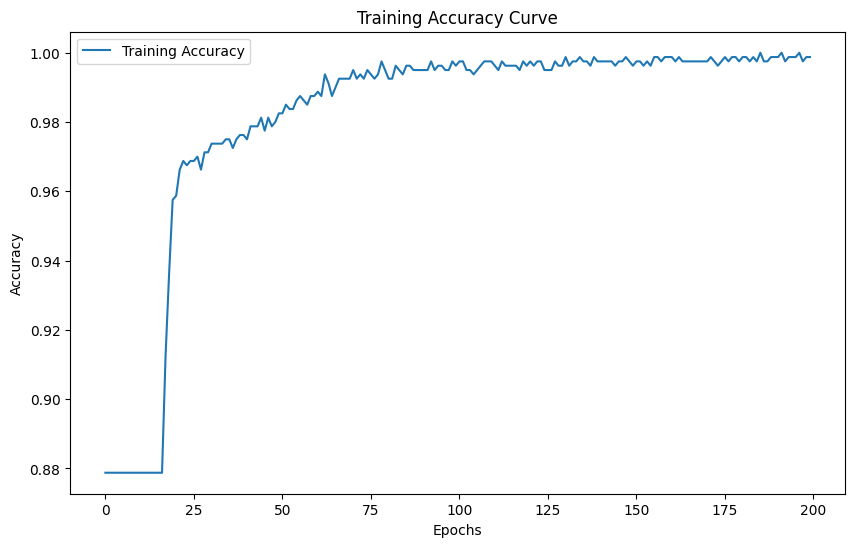

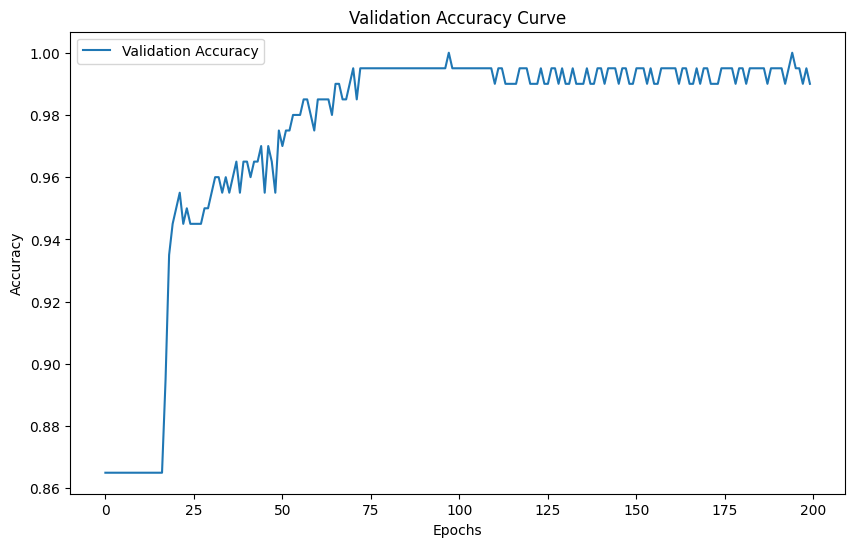

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

seed = 15
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


data = pd.read_csv('dataset.csv')
X = data[['x', 'y']].values
y = data['label'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(2, 4) 
        self.out = nn.Linear(4, 1)  
        self.custom_sigmoid = torch.sigmoid

    def forward(self, x):
        x = self.custom_sigmoid(self.hidden(1*x))
        x = torch.sigmoid(self.out(1*x))
        return x
    

def evaluate(model, X, y):
    with torch.no_grad():
        y_pred = model(X)
        y_pred = (y_pred > 0.5).float()
        acc = accuracy_score(y, y_pred)
    return acc


model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
loss_function = nn.MSELoss() 


losses = []
train_accs = []
test_accs = []
num_epochs = 200 

acc_train = evaluate(model, X_train_tensor, y_train_tensor)
acc_test = evaluate(model, X_test_tensor, y_test_tensor)
print(f"Baseline train Acc: {acc_train:.4f}, test Acc: {acc_test:.4f}")
best_acc = acc_test
model_parameters = None

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch", leave=False) as tepoch:
        for inputs, targets in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            
            optimizer.zero_grad()
            outputs = model(inputs)
            model_loss = loss_function(outputs, targets)
            loss = model_loss
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            tepoch.set_postfix(model_loss=model_loss.item())


        acc_train = evaluate(model, X_train_tensor, y_train_tensor)
        acc_test = evaluate(model, X_test_tensor, y_test_tensor)
        train_accs.append(acc_train)
        test_accs.append(acc_test)
        if acc_test > best_acc:
            best_acc = acc_test
            model_parameters = deepcopy(model.state_dict())
            

acc_train = evaluate(model, X_train_tensor, y_train_tensor)
acc_test = evaluate(model, X_test_tensor, y_test_tensor)
print(f"After train Acc: {acc_train:.4f}, test Acc: {acc_test:.4f}")


print(f"Best test accuracy: {best_acc:.4f}")
print(model_parameters)

# save training log
training_log_df = pd.DataFrame({
    'train_acc': train_accs,
    'test_acc': test_accs
})
training_log_df.to_csv('computer_training_log.csv', index=False)

plt.figure(figsize=(10, 6))
plt.plot(train_accs, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()


# Neuromorphic array

Baseline train Acc: 0.6737, test Acc: 0.6650


After train Acc: 0.9812, test Acc: 0.9550
Best test accuracy: 1.0000
OrderedDict({'hidden.weight': tensor([[-0.7700, -0.0700],
        [ 0.9300, -0.0700],
        [ 0.3200,  0.8600],
        [-0.1900,  0.8900]]), 'hidden.bias': tensor([-1.0100, -1.9400,  1.8800, -1.9800]), 'out.weight': tensor([[-0.9200, -2.2200,  1.8100, -1.8400]]), 'out.bias': tensor([-0.0300])})


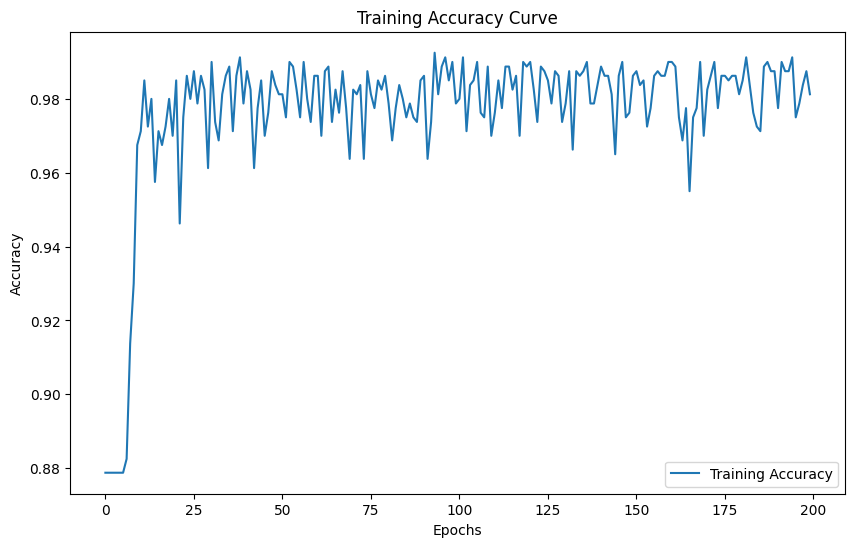

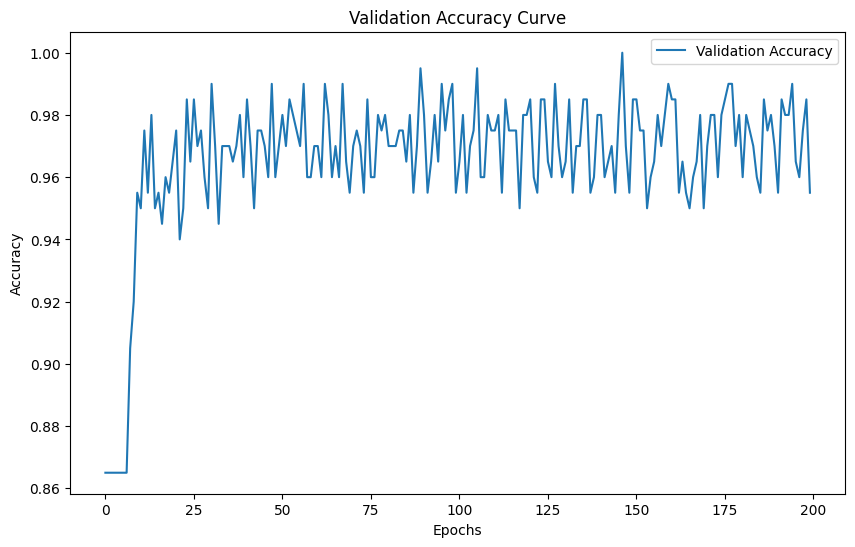

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
from copy import deepcopy

seed = 31
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


data = pd.read_csv('dataset.csv')
X = data[['x', 'y']].values
y = data['label'].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)


class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(2, 4) 
        self.out = nn.Linear(4, 1)  
        self.custom_sigmoid = torch.sigmoid

    def forward(self, x):
        x = self.custom_sigmoid(self.hidden(8*x))
        x = torch.sigmoid(self.out(4*x))
        return x
    

def l2_regularization(model, lambda_l2):
    l2 = 0
    for param in model.parameters():
        l2 += torch.norm(param)**2
    return lambda_l2 * l2

def evaluate(model, X, y):
    with torch.no_grad():
        y_pred = model(X)
        y_pred = (y_pred > 0.5).float()
        acc = accuracy_score(y, y_pred)
    return acc


model = MLP()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  
lambda_l2 = 0.001
loss_function = nn.MSELoss() 


losses = []
train_accs = []
test_accs = []
num_epochs = 200 

acc_train = evaluate(model, X_train_tensor, y_train_tensor)
acc_test = evaluate(model, X_test_tensor, y_test_tensor)
print(f"Baseline train Acc: {acc_train:.4f}, test Acc: {acc_test:.4f}")
best_acc = acc_test
model_parameters = None

for epoch in range(num_epochs):
    with tqdm(train_loader, unit="batch", leave=False) as tepoch:
        for inputs, targets in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")
            
            optimizer.zero_grad()
            outputs = model(inputs)
            model_loss = loss_function(outputs, targets)
            regularization_loss = l2_regularization(model, lambda_l2)
            loss = model_loss + regularization_loss
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            tepoch.set_postfix(model_loss=model_loss.item(), regularization_loss=regularization_loss.item())

        model_copy = MLP()
        model_copy.load_state_dict(model.state_dict())
        for parameter in model_copy.parameters():
            parameter.data = torch.round(parameter.data, decimals=2)

        acc_train = evaluate(model, X_train_tensor, y_train_tensor)
        acc_test = evaluate(model, X_test_tensor, y_test_tensor)
        train_accs.append(acc_train)
        test_accs.append(acc_test)
        if acc_test > best_acc:
            best_acc = acc_test
            model_parameters = deepcopy(model_copy.state_dict())


acc_train = evaluate(model, X_train_tensor, y_train_tensor)
acc_test = evaluate(model, X_test_tensor, y_test_tensor)
print(f"After train Acc: {acc_train:.4f}, test Acc: {acc_test:.4f}")


print(f"Best test accuracy: {best_acc:.4f}")
print(model_parameters)

# save training log
training_log_df = pd.DataFrame({
    'train_acc': train_accs,
    'test_acc': test_accs
})
training_log_df.to_csv('synapse_training_log.csv', index=False)

plt.figure(figsize=(10, 6))
plt.plot(train_accs, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Curve')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.show()
